In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
%matplotlib inline

In [2]:
# import from models folder
sys.path.append(os.path.abspath('../models'))
sys.path.append(os.path.abspath('../data'))

In [3]:
confmat = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=3, normalize='true')
confmat_bin = torchmetrics.ConfusionMatrix(task='binary', num_classes=2, normalize='true')

def save_metrics(name, y_pred, y_true):

    y_true = y_true.flatten()
    y_pred = y_pred.numpy().flatten()

    dict_df = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(dict_df).transpose()
    df.to_csv('metrics_' + name + '.csv', index=False)

def conf_matrix(name, y_pred, y_true):

    y_true = torch.from_numpy(y_true)
    confmat.update(y_pred.flatten(), y_true.flatten())
    cm = confmat.compute()

    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.round(decimals=10), annot=True, cmap='Blues')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    plt.savefig('confmat_' + name + '.png')
    np.save('confmat_' + name + '.npy', cm.round(decimals=10).numpy())

# 1. Cargamos los datos

Hay que cargar los datos de nuestra base de datos para los incendios forestales.

In [4]:
import pickle
# we want to load dict_data_final.pkl
with open('..\\data\\dict_data_final.pkl', 'rb') as f:
    dict_data = pickle.load(f)

In [5]:
dict_data

{'Artana': (                     Temperatura  Humedad       Rho     Theta  Train
  Fecha                                                               
  2016-07-25 15:00:00        28.81    44.63  0.908365  2.652900   True
  2016-07-25 15:30:00        27.61    49.51  0.894910  2.474877  False
  2016-07-25 16:00:00        27.30    53.80  0.814218  2.537709   True
  2016-07-25 16:30:00        27.42    52.78  0.794672  2.448697  False
  2016-07-25 17:00:00        27.51    50.66  0.758823  2.431244  False
  ...                          ...      ...       ...       ...    ...
  2016-07-27 10:00:00        27.81    62.03  0.656967  2.405064  False
  2016-07-27 10:30:00        27.01    67.93  0.648663  2.012365  False
  2016-07-27 11:00:00        27.86    65.52  0.790158  2.183407  False
  2016-07-27 11:30:00        27.21    67.24  0.783200  2.638938  False
  2016-07-27 12:00:00        27.10    68.17  0.827459  2.565634   True
  
  [91 rows x 5 columns],
  array([[[0., 0., 0., ..., 0., 0., 0.]

# 2. Fijamos los parámetros del modelo

In [6]:
P = [0.1, 0.5, 0.9]
C, p0 = 2, 0.5
inc = 1
n_it = 100

# 3. Resultados del modelo para Beneixama

Vamos a obtener los resultados del modelo para el caso del incendio de BENEIXAMA.

## 3.0. Datos iniciales

In [7]:
from baseline import *

x, y = dict_data['Beneixama']

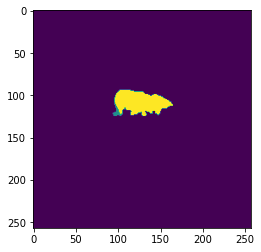

In [8]:
plt.imshow(y[:, :, -1])

## 3.1. Baseline

In [9]:
baseline = Grid(x=x, y=y)
baseline.initialize(inc=inc, part=P, p0=p0, div=C)
baseline.submatrix()
baseline.enlargement_process()
baseline.montecarlo(n_it=n_it)

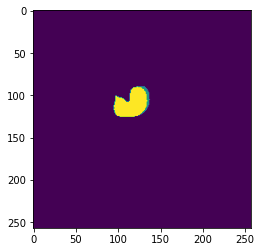

In [10]:
plt.imshow(baseline.X.numpy()[:, :, -1])

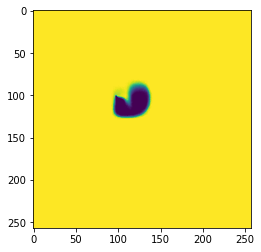

In [11]:
plt.imshow(baseline.X0.numpy()[:, :, -1])

In [12]:
save_metrics('base_Beneixama', y_pred=baseline.X[:, :, -1], y_true=y[:, :, -1])

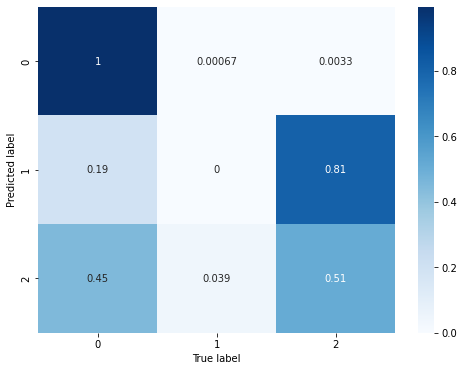

In [13]:
conf_matrix('base_Beneixama', y_pred=baseline.X[:, :, -1], y_true=y[:, :, -1])

In [14]:
m = np.load('confmat_base_Beneixama.npy')
m

array([[9.9606639e-01, 6.6591299e-04, 3.2676195e-03],
       [1.9402985e-01, 0.0000000e+00, 8.0597013e-01],
       [4.5067424e-01, 3.9034776e-02, 5.1029098e-01]], dtype=float32)

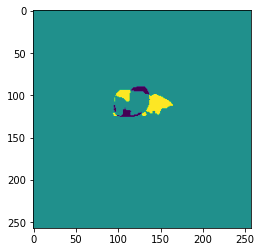

In [15]:
X = baseline.X.clone().detach()
y_bin = torch.from_numpy(y).clone()

X_bin = torch.where(
    X == 0,
    0,
    1
)

y_bin = torch.where(
    y_bin == 0,
    0,
    1
)

misclass = (y_bin[:, :, -1] - X_bin[:, :, -1]).to(torch.float32)
plt.imshow(misclass)

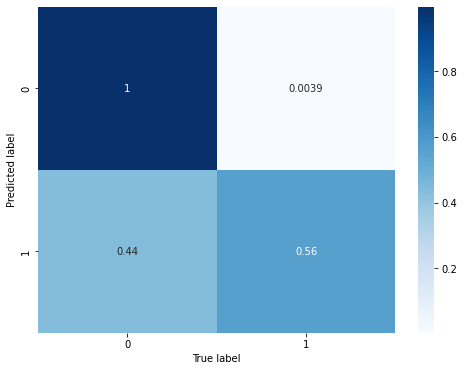

In [16]:
confmat_bin.update(X_bin[:, :, -1].flatten(), y_bin[:, :, -1].flatten())
cm_bin = confmat_bin.compute()

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, cmap='Blues')
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.savefig('confmat_bin_base.png')
np.save('confmat_bin_base.npy', cm_bin.numpy())
plt.show()

## 3.2. T-H model

In [17]:
from thmodel import *

In [18]:
thmodel = Grid(x=x, y=y)
thmodel.initialize(inc=inc, part=P)
thmodel.compute_th_param()
thmodel.submatrix()
thmodel.enlargement_process()
thmodel.montecarlo(n_it=n_it)

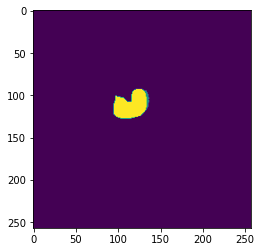

In [19]:
plt.imshow(thmodel.X.numpy()[:, :, -1])

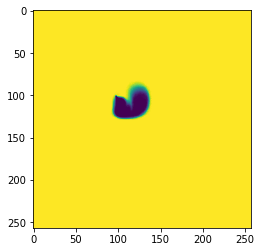

In [20]:
plt.imshow(thmodel.X0.numpy()[:, :, -1])

In [21]:
save_metrics('th_Beneixama', y_pred=thmodel.X[:, :, -1], y_true=y[:, :, -1])

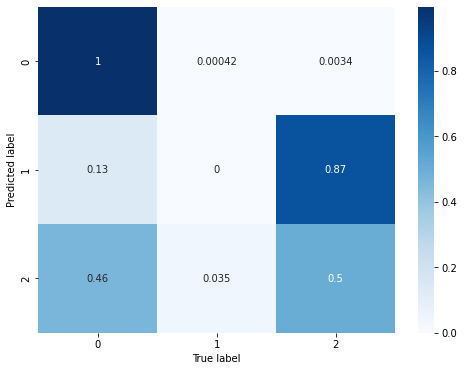

In [22]:
conf_matrix('th_Beneixama', y_pred=thmodel.X[:, :, -1], y_true=y[:, :, -1])

In [23]:
m = np.load('confmat_th_Beneixama.npy')
m

array([[9.9620587e-01, 4.1813141e-04, 3.3760241e-03],
       [1.3432837e-01, 0.0000000e+00, 8.6567169e-01],
       [4.5990068e-01, 3.5131298e-02, 5.0496805e-01]], dtype=float32)

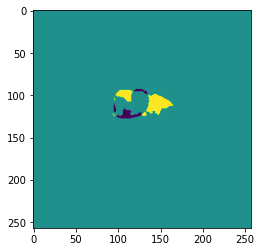

In [24]:
X = thmodel.X.clone().detach()
y_bin = torch.from_numpy(y).clone()

X_bin = torch.where(
    X == 0,
    0,
    1
)

y_bin = torch.where(
    y_bin == 0,
    0,
    1
)

misclass = (y_bin[:, :, -1] - X_bin[:, :, -1]).to(torch.float32)
plt.imshow(misclass)

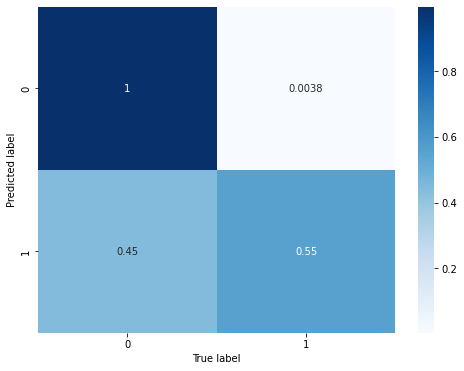

In [25]:
confmat_bin.update(X_bin[:, :, -1].flatten(), y_bin[:, :, -1].flatten())
cm_bin = confmat_bin.compute()

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, cmap='Blues')
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.savefig('confmat_bin_th.png')
np.save('confmat_bin_th.npy', cm_bin.numpy())
plt.show()